In [1]:
import numpy as np 
import pandas as pd
import h5py 
from tqdm import tqdm
from seemps.state import CanonicalMPS, Strategy

import matplotlib.pyplot as plt
import seaborn as sns  
import scienceplots
plt.style.use(['science','nature','grid'])
plt.rcParams.update({'figure.dpi': '250'})

from Q2MPS.q2MPSalgorithm import IterativeQ2algorithm
from Q2MPS.MPS_utils import probability_amplitude
from Q2MPS.utils import all_bit_strings, SKenergy

This notebook shows an example of the application of the generative algorithm based on Matrix Product States to the simulation of probability distributions associated with generalized statistical mechanics of Ising models  (more details on paper $\textit{Learning Generalized Statistical Mechanics with Matrix Product States}$).

## Load problem

We study the behaviour of instances of Ising models with energy $$E(\mathbf{s})=1/2\sum_{i,j}J_{ij} s_i s_j\,,$$ where $J_{i,j}=J_{j,i}$ and $s_i \in \{-1,+1\}$.

In [2]:
N = 16 #Number of variables
samples = 500
degree = 6
ptype = f'regulargraph{degree}'

file_name = f'Problems/J_{ptype}_{N}q_{samples}samples.hdf5'

sample = 0
with h5py.File(file_name,"r") as data:
    J = data[f'Sample{sample}']['J'][()]

## Generate generalized thermal distributions

We generate the generalized thermal distributions, $$p_{q=2}(\mathbf{s})=\max\left[-\frac{\beta}{2} E(\mathbf{s})+\tau, 0\right]$$
at different inverse temperatures $\beta$ by the minimization of the generalized free energy,
$$F^{\beta}_{q=2}(p_{\bm{\theta}})=\sum_\mathbf{s} E(\mathbf{s}) p_{\bm{\theta}}(\mathbf{s}) - \frac{1}{\beta}\left(1-\sum_\mathbf{s} p_{\bm{\theta}}(\mathbf{s})^2\right)\,,$$
and the MPS algorithm described in paper $\textit{Learning Generalized Statistical Mechanics with Matrix Product States}$.

In [3]:
χ = 12 #Maximum bond dimension

alg = IterativeQ2algorithm(J,χ) #Initialize the algorithm

#Define the initial and final betas (in logarithmic scale) of the annealing process
β0 = -7
βsteps = 20 #Number of annealing steps
βfs = [np.log10(0.005), np.log10(0.05), np.log10(0.25),np.log10(0.5)]

In [4]:
bits = all_bit_strings(N)
E = SKenergy(bits,J)/N 

probabilityamplitude_list = []
beta_list = []
for βf in βfs:
    #Run the algorithms
    history_annealing, mps = alg.annealing(β0,βf, avqtol=1, print_info=False, method='L-BFGS-B', maxiter=100, β_scheme='log',steps=βsteps , tol=10**(-4))
    #Calculate the probability amplitudes of the final MPS
    seemps_mps = CanonicalMPS(mps.A_mpsstate,center=0, strategy=Strategy(method=0), normalize=True)
    for b in tqdm([bits[:,x] for x in range(2**N)]):
        probabilityamplitude_list.append(probability_amplitude(b,seemps_mps,norm_mps=None))
        beta_list.append(10**(βf))

Optimitation stopped after 59 sweeps with beta:0.004999999999999999 Norm:0.9999999999999983 GSprob: None Avq: 0.00035006735220462015 Eres: 0 Relative error: None


100%|██████████| 65536/65536 [00:23<00:00, 2793.58it/s]


Optimitation stopped after 65 sweeps with beta:0.049999999999999996 Norm:1.0000000000000016 GSprob: None Avq: 0.003050776586376909 Eres: 0 Relative error: None


100%|██████████| 65536/65536 [00:23<00:00, 2793.41it/s]


Optimitation stopped after 70 sweeps with beta:0.25 Norm:1.0000000000000029 GSprob: None Avq: 0.013762768879339936 Eres: 0 Relative error: None


100%|██████████| 65536/65536 [00:22<00:00, 2865.31it/s]


Optimitation stopped after 69 sweeps with beta:0.5 Norm:1.0000000000000022 GSprob: None Avq: 0.025498424199338492 Eres: 0 Relative error: None


100%|██████████| 65536/65536 [00:23<00:00, 2795.79it/s]


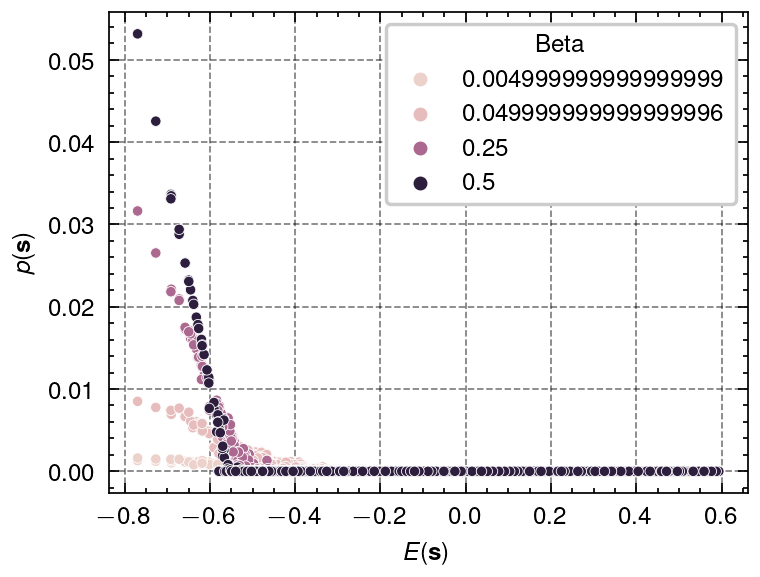

In [5]:
dataframe_numerical = pd.DataFrame(data={'Probabilities':probabilityamplitude_list, 'Beta':beta_list, 'Energy':np.concatenate((E,E,E,E))})

sns.scatterplot(data=dataframe_numerical, x='Energy', y='Probabilities', hue='Beta')
plt.xlabel(r'$E(\mathbf{s})$')
plt.ylabel(r'$p(\mathbf{s})$')
plt.show()